In [15]:
# Notebookloader is needed to import ipython notebooks as python modules.
import NotebookLoader
import Function_definitions as fn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import units
from recarray_tools import append_fields
from tqdm import tqdm

In [2]:
# Open the file
store = h5py.File('D:/Documenten/PhD/Data/run6_hdf/run-6_measurement-001.hdf5')

# Slurp all events and peaks in to memory
events = store['Event'][:]
peaks = store['Peak'][:]
n_events = len(events)
print("Number of events: ",n_events)

Number of events:  343881


In [3]:
# Append fields to the event and peak list. Only the ones that can be directly determined from the events lists
# full range: the total time of the peak.
peaks = append_fields(peaks, 'width', (peaks['right'] - peaks['left'] + 1)*fn.dt)
peaks = append_fields(peaks,'mid',peaks['left']*fn.dt + 0.5* peaks['width'])

# Recalculate because of wrong ordering
peaks['area_fraction_top'] = peaks['area_per_channel'][:,3] / peaks['area']

# append empty fields for the properties that are to be computed.
events = append_fields(events,'drift_time',np.zeros([n_events]))
events = append_fields(events,'s1_and_s2',np.zeros([n_events], dtype=np.bool))

events = append_fields(events,'s1_area',np.zeros([n_events]))
events = append_fields(events,'s1_width',np.zeros([n_events]))
events = append_fields(events,'s1_mid',np.zeros([n_events]))
events = append_fields(events,'s1_area_fraction_top',np.zeros([n_events]))

events = append_fields(events,'s2_area',np.zeros([n_events]))
events = append_fields(events,'s2_width',np.zeros([n_events]))
events = append_fields(events,'s2_mid',np.zeros([n_events]))
events = append_fields(events,'s2_area_fraction_top',np.zeros([n_events]))

In [4]:
# Group peaks by event
peaks_per_event = fn.group_by(peaks, 'Event')

# Get the main s1 / s2 of an event
# This funciton is in here because it needs the list defined above, and we may want to change the S1/S2 classification
def get_main_peak(event_nr, peak_type):
    pks = peaks_per_event[event_nr]
    
    if peak_type != 's1' and peak_type != 's2':
        print('Sytax error')
    # S1 properties
    if peak_type == 's1':
        # 'Default' from processer
        # pks = pks[pks['type'] == b's1' ]
        
        # Make sure both channels contribute
        pks = pks[pks['does_channel_contribute'][:,0]]
        pks = pks[pks['does_channel_contribute'][:,3]]
        # Width cut
        pks = pks[(pks['right']-pks['left']) * fn.dt < 400]
        
    # S2 properties
    if peak_type == 's2':
        # 'Default' from processer
        # pks = pks[pks['type'] == b's2' ]
        
        # Make sure both channels contribute
        pks = pks[pks['does_channel_contribute'][:,0]]
        pks = pks[pks['does_channel_contribute'][:,3]]
        # Width cut
        pks = pks[(pks['right']-pks['left']) * fn.dt > 400]
        
    
    if len(pks):
        return max(pks, key=lambda x:x['area'])
    else:
        return None

In [9]:
counter_s1_and_s2 = 0
peaks['area_fraction_top'] = peaks['area_per_channel'][:,3] / peaks['area']
# Main loop.
for e in np.arange(len(events)):
    main_s1 = get_main_peak(e, 's1')
    main_s2 = get_main_peak(e, 's2')
    if not (main_s1 and main_s2):
    # If event is missing one of the main peak types, move on
        continue
    # We have an S1 and an S2! Increase counter and compute properties
    counter_s1_and_s2 +=1
    events['s1_and_s2'][e] = True
    events['drift_time'] = main_s2['mid'] - main_s1['mid']
    
    events['s1_area'][e] = main_s1['area']
    events['s1_width'][e] = main_s1['width']
    events['s1_mid'][e] = main_s1['mid']
    events['s1_area_fraction_top'] = main_s1['area_fraction_top']
    events['s2_area'][e] = main_s2['area']
    events['s2_width'][e] = main_s2['width']
    events['s2_mid'][e] = main_s2['mid']
    events['s2_area_fraction_top'] = main_s2['area_fraction_top']
#     s1_area = main_s1['area']
#     s2_width = fn.dt*(main_s2['right']-main_s2['left'])
#     s2_area= main_s2['area']
#     drift_time = fn.dt * (main_s2['index_of_maximum'] - main_s1['index_of_maximum'])
#     timestamp = events['start_time'][e]/(1e9)
#     s1_area_fraction =( main_s1['area_per_channel'][3] / (main_s1['area_per_channel'][0] + main_s1['area_per_channel'][3]))
#     s2_area_fraction =( main_s2['area_per_channel'][3] / (main_s2['area_per_channel'][0] + main_s2['area_per_channel'][3]))

KeyboardInterrupt: 

In [13]:
# Add full_range peak width
peaks = append_fields(peaks, 'full_range', (peaks['right'] - peaks['left'] + 1)*fn.dt)

<function matplotlib.pyplot.show>

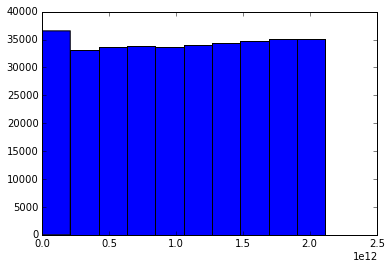

In [8]:
plt.hist(events['start_time'])
plt.show

<function matplotlib.pyplot.show>

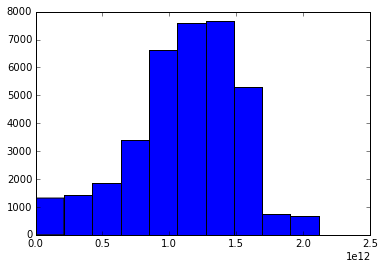

In [9]:
plt.hist(events[events['s1_and_s2']]['start_time'])
plt.show

In [7]:
peaks.dtype.names

('Event',
 'Peak',
 'area',
 'area_fraction_top',
 'area_per_channel',
 'bottom_hitpattern_spread',
 'detector',
 'does_channel_contribute',
 'does_channel_have_noise',
 'height',
 'hit_time_mean',
 'hit_time_std',
 'index_of_maximum',
 'left',
 'median_absolute_deviation',
 'right',
 'top_hitpattern_spread',
 'type',
 'full_range')

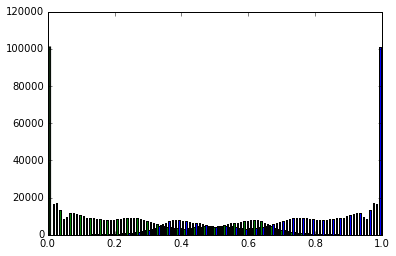

In [13]:
plt.hist((peaks['area_fraction_top'],peaks['area_per_channel'][:,3]/peaks['area']),bins =100 )
plt.show()

In [11]:
peaks['mid']

array([ 83783.,  83738.,  83768., ...,  83767.,  83752.,  83724.])

In [19]:
for i in tqdm(range(10000)):
    1+1